In [1]:
pip install librosa pandas numpy scikit-learn matplotlib tqdm soundfile

Note: you may need to restart the kernel to use updated packages.


In [15]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

BASE_DIR = "./datasets"
TESS_DIR = os.path.join(BASE_DIR, "tess")
CREMA_DIR = os.path.join(BASE_DIR, "crema-d")
RAVDESS_DIR = os.path.join(BASE_DIR, "ravdess-data")

SAMPLE_RATE = 22050



In [16]:
# For TESS
def load_tess():
    data = []
    for folder in os.listdir(TESS_DIR):
        emotion = folder.split("_")[-1].lower()
        folder_path = os.path.join(TESS_DIR, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                path = os.path.join(folder_path, file)
                data.append((path, emotion))
    return data

# For CREMA-D
def load_crema_d():
    emotion_map = {
        "ANG": "angry", "DIS": "disgust", "FEA": "fearful",
        "HAP": "happy", "NEU": "neutral", "SAD": "sad"
    }
    data = []
    for file in os.listdir(CREMA_DIR):
        if file.endswith(".wav"):
            parts = file.split("_")
            emotion = emotion_map.get(parts[2], None)
            if emotion:
                path = os.path.join(CREMA_DIR, file)
                data.append((path, emotion))
    return data

# For RAVDESS
def load_ravdess():
    emotion_map = {
        "01": "neutral", "02": "calm", "03": "happy",
        "04": "sad", "05": "angry", "06": "fearful",
        "07": "disgust", "08": "surprised"
    }
    data = []
    for root, _, files in os.walk(RAVDESS_DIR):
        for file in files:
            if file.endswith(".wav"):
                parts = file.split("-")
                emotion = emotion_map.get(parts[2], None)
                if emotion:
                    path = os.path.join(root, file)
                    data.append((path, emotion))
    return data


In [17]:
# Load and merge datasets
tess_data = load_tess()
crema_data = load_crema_d()
ravdess_data = load_ravdess()

all_data = tess_data + crema_data + ravdess_data

print(f"✅ Total samples loaded: {len(all_data)}")

# Show few examples
import random
random.shuffle(all_data)
for i in range(5):
    print(all_data[i])


✅ Total samples loaded: 13122
('./datasets\\crema-d\\1009_ITS_SAD_XX.wav', 'sad')
('./datasets\\ravdess-data\\Actor_03\\03-01-06-02-02-01-03.wav', 'fearful')
('./datasets\\crema-d\\1016_ITS_SAD_XX.wav', 'sad')
('./datasets\\crema-d\\1048_ITS_DIS_XX.wav', 'disgust')
('./datasets\\crema-d\\1043_IEO_ANG_LO.wav', 'angry')


In [18]:
def extract_features(file_path, sample_rate=22050):
    try:
        audio, _ = librosa.load(file_path, sr=sample_rate, res_type="kaiser_fast")
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [19]:
features = []
labels = []

for path, label in tqdm(all_data):
    mfcc = extract_features(path)
    if mfcc is not None:
        features.append(mfcc)
        labels.append(label)

print(f"✅ Extracted features from {len(features)} files.")


100%|██████████| 13122/13122 [15:33<00:00, 14.05it/s]

✅ Extracted features from 13122 files.


In [20]:
df = pd.DataFrame(features)
df["label"] = labels
df.to_csv("features.csv", index=False)

print("✅ Saved features to features.csv")
df.head()


✅ Saved features to features.csv


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-456.575043,136.527435,2.376009,77.083122,-14.112505,29.339159,-16.671497,9.267215,-1.253794,-2.970204,...,-0.711211,3.937225,0.964934,1.566782,5.738392,2.600578,4.867594,1.833079,2.628369,sad
1,-394.742401,55.541351,-14.053243,13.811595,-3.965402,11.300798,-15.225402,-10.086811,-14.587361,-7.588269,...,7.441703,2.829896,4.759306,4.116480,5.901830,4.481123,0.525577,1.241355,2.621771,fearful
2,-426.375854,128.391068,12.472813,63.383026,-3.735512,26.996208,-11.805341,4.912915,-2.963334,-4.163063,...,-0.200079,2.048320,0.998026,-0.326989,4.049694,1.339910,2.259127,0.366075,0.656739,sad
3,-430.908691,134.530640,14.693838,59.866104,-11.650968,23.415775,-10.857422,1.775726,-1.164114,-4.168240,...,0.391836,0.689333,0.742341,-0.856530,1.504890,-0.419310,3.772069,3.194642,4.069006,disgust
4,-417.087708,145.348679,7.123462,50.162643,-17.542011,22.157343,-4.430702,-0.816537,-7.286849,-0.264768,...,3.198484,2.261936,1.898040,-1.779070,0.567067,-2.546989,1.743609,-0.963485,-0.419872,angry


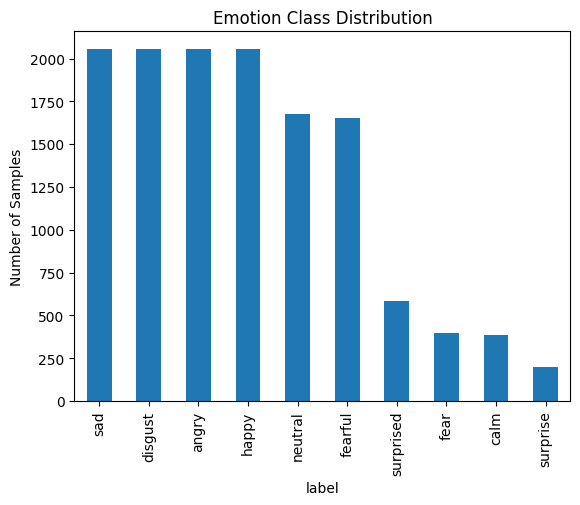

In [21]:
df["label"].value_counts().plot(kind='bar', title='Emotion Class Distribution')
plt.ylabel("Number of Samples")
plt.show()


In [22]:
from sklearn.preprocessing import LabelEncoder

# Encode emotion labels as integers
le = LabelEncoder()
df["encoded_label"] = le.fit_transform(df["label"])

# Save label classes to use later in prediction
import joblib
joblib.dump(le, "label_encoder.pkl")

# Features and targets
X = df.drop(columns=["label", "encoded_label"]).values
y = df["encoded_label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Data split into training and testing sets.")


✅ Data split into training and testing sets.


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.6620952380952381

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.82      0.75       411
           1       0.87      1.00      0.93        77
           2       0.63      0.53      0.58       411
           3       1.00      1.00      1.00        80
           4       0.58      0.39      0.47       331
           5       0.57      0.54      0.55       411
           6       0.57      0.65      0.61       336
           7       0.67      0.74      0.70       411
           8       1.00      1.00      1.00        40
           9       0.93      0.95      0.94       117

    accuracy                           0.66      2625
   macro avg       0.75      0.76      0.75      2625
weighted avg       0.66      0.66      0.65      2625



In [24]:
import joblib
joblib.dump(model, "emotion_model.pkl")
print("✅ Model saved as emotion_model.pkl")


✅ Model saved as emotion_model.pkl
